In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.utils import get_file
from sklearn.metrics.pairwise import cosine_similarity

np.set_printoptions(precision=3)

In [2]:
movies_df = pd.read_csv("D:/추천 시스템/movies.csv", index_col=0)
genres_df = pd.read_csv("D:/추천 시스템/genres.csv", index_col=0)
ratings_df = pd.read_csv("D:/추천 시스템/ratings.csv", index_col=0)

ratings_df = ratings_df.drop(["rated_at"], axis=1)
id2title = dict(zip(movies_df["id"], movies_df["title"]))
ratings_df["title"] = ratings_df["movie_id"].map(id2title)

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.0\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
ratings_df

,user_id,movie_id,rating,title
0,1,2,3.5,Jumanji
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p..."
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys)
3,1,47,3.5,Seven (a.k.a. Se7en)
4,1,50,3.5,"Usual Suspects, The"
...,...,...,...,...
20000258,138493,68954,4.5,Up
20000259,138493,69526,4.5,Transformers: Revenge of the Fallen
20000260,138493,69644,3.0,Ice Age: Dawn of the Dinosaurs
20000261,138493,70286,5.0,District 9


In [4]:
n_user = ratings_df["user_id"].nunique()
n_item = ratings_df["movie_id"].nunique()

print(f"density : {len(ratings_df)/(n_user*n_item)*100:>.2f}%")

density : 0.54%


In [5]:
n_rating_item = ratings_df["movie_id"].value_counts()

In [7]:
n_rating_item

296       67310
356       66172
318       63366
593       63299
480       59715
          ...  
123607        1
90823         1
123609        1
123613        1
131136        1
Name: movie_id, Length: 26744, dtype: int64

In [8]:
n_rating_user = ratings_df["user_id"].value_counts()

In [9]:
n_rating_user

118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
          ... 
59390       20
23558       20
34668       20
80291       20
58028       20
Name: user_id, Length: 138493, dtype: int64

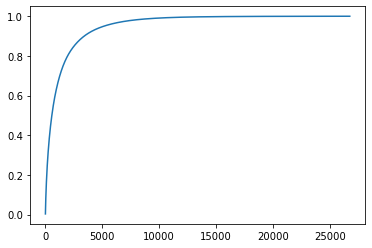

In [10]:
cumsum_item = n_rating_item.cumsum()/len(ratings_df)

fig, ax = plt.subplots()

ax.plot(cumsum_item.reset_index(drop=True))

In [11]:
cumsum_item

296       0.003365
356       0.006674
318       0.009842
593       0.013007
480       0.015993
            ...   
123607    1.000000
90823     1.000000
123609    1.000000
123613    1.000000
131136    1.000000
Name: movie_id, Length: 26744, dtype: float64

In [12]:
concat_item = pd.concat([n_rating_item, cumsum_item], axis=1)
concat_item.columns = ["n_rating", "cumsum"]

In [13]:
concat_item

,n_rating,cumsum
296,67310,0.003365
356,66172,0.006674
318,63366,0.009842
593,63299,0.013007
480,59715,0.015993
...,...,...
123607,1,1.000000
90823,1,1.000000
123609,1,1.000000
123613,1,1.000000


In [14]:
thrsd_item = concat_item[concat_item["cumsum"]<=0.9]["n_rating"].min()

concat_item[concat_item["n_rating"]>=thrsd_item]

,n_rating,cumsum
296,67310,0.003365
356,66172,0.006674
318,63366,0.009842
593,63299,0.013007
480,59715,0.015993
...,...,...
927,880,0.899943
510,879,0.899987
27731,879,0.900031
2937,879,0.900075


In [15]:
over_thrsd_item = concat_item[concat_item["n_rating"]>=thrsd_item].index

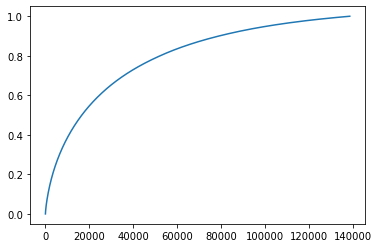

In [16]:
cumsum_user = n_rating_user.cumsum()/len(ratings_df)

fig, ax = plt.subplots()

ax.plot(cumsum_user.reset_index(drop=True))

In [17]:
cumsum_user

118205    0.000463
8405      0.000838
82418     0.001121
121535    0.001397
125794    0.001671
            ...   
59390     0.999996
23558     0.999997
34668     0.999998
80291     0.999999
58028     1.000000
Name: user_id, Length: 138493, dtype: float64

In [18]:
concat_user = pd.concat([n_rating_user, cumsum_user], axis=1)
concat_user.columns = ["n_rating", "cumsum"]

In [19]:
concat_user

,n_rating,cumsum
118205,9254,0.000463
8405,7515,0.000838
82418,5646,0.001121
121535,5520,0.001397
125794,5491,0.001671
...,...,...
59390,20,0.999996
23558,20,0.999997
34668,20,0.999998
80291,20,0.999999


In [20]:
thrsd_user = concat_user[concat_user["cumsum"]<=0.9]["n_rating"].min()

concat_user[concat_user["n_rating"]>=thrsd_user]

,n_rating,cumsum
118205,9254,0.000463
8405,7515,0.000838
82418,5646,0.001121
121535,5520,0.001397
125794,5491,0.001671
...,...,...
100427,56,0.900366
113902,56,0.900368
14782,56,0.900371
8879,56,0.900374


In [21]:
over_thrsd_user = concat_user[concat_user["n_rating"]>=thrsd_user].index

In [22]:
ratings_df_tr = ratings_df[(ratings_df["user_id"].isin(over_thrsd_user)) & ratings_df["movie_id"].isin(over_thrsd_item)]

In [23]:
ratings_df_tr

,user_id,movie_id,rating,title
0,1,2,3.5,Jumanji
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p..."
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys)
3,1,47,3.5,Seven (a.k.a. Se7en)
4,1,50,3.5,"Usual Suspects, The"
...,...,...,...,...
20000257,138493,68319,4.5,X-Men Origins: Wolverine
20000258,138493,68954,4.5,Up
20000259,138493,69526,4.5,Transformers: Revenge of the Fallen
20000260,138493,69644,3.0,Ice Age: Dawn of the Dinosaurs


In [24]:
ui = pd.pivot_table(ratings_df_tr, index="user_id", columns="movie_id", values="rating")

# ui.to_csv("D:/☆디지털혁신팀/☆실거래가 분석/☆그래프/User-Item Matrix.csv")

In [25]:
ui

movie_id,1,2,3,4,5,6,7,8,9,10,...,106920,108932,109374,109487,110102,111362,111759,112290,112556,112852
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138486,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
mean_user = ui.mean(axis=1)
mean_item = ui.mean(axis=0)
mean_tot = ui.mean().mean()

ui_adj = ui.sub(mean_user, axis=0).sub(mean_item, axis=1) + 2*mean_tot

In [28]:
ui_adj

movie_id,1,2,3,4,5,6,7,8,9,10,...,106920,108932,109374,109487,110102,111362,111759,112290,112556,112852
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.357315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,3.670128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.749197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2.334588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,3.379104,NaN,NaN,NaN,3.13425,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138486,4.027747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
ui_norm_user = ui_adj.div(np.sqrt((ui_adj**2).sum(axis=1)), axis=0)
ui_norm_user = ui_norm_user.fillna(0)

ui_norm_item = ui_adj.div(np.sqrt((ui_adj**2).sum(axis=0)), axis=1)

ui_norm_item = ui_norm_item.fillna(0)

In [36]:
ui_norm_user = ui_norm_user.fillna(0)
ui_norm_item = ui_norm_item.fillna(0)

In [34]:
ui_norm_user

movie_id,1,2,3,4,5,6,7,8,9,10,...,106920,108932,109374,109487,110102,111362,111759,112290,112556,112852
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,0.083990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.141259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.059859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,0.087759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,0.060554,NaN,NaN,NaN,0.056166,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138486,0.087634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# (ui_norm_item**2).sum(axis=0)

In [33]:
# (ui_norm_user**2).sum(axis=1)

In [37]:
# cos_sim_user = np.dot(ui_norm_user, ui_norm_user.T)

In [101]:
%%time
cos_sim_item = np.dot(ui_norm_item.T, ui_norm_item)
np.fill_diagonal(cos_sim_item, 0)

cos_sim_item = pd.DataFrame(cos_sim_item, columns=ui.columns, index=ui.columns)

cos_sim_item.columns = [id2title[idx] for idx in cos_sim_item.columns]
cos_sim_item.index = [id2title[idx] for idx in cos_sim_item.index]

# cos_sim_item.to_csv("D:/☆디지털혁신팀/☆실거래가 분석/☆그래프/Cosine Similarity of Movies.csv")

Wall time: 52.1 s


In [56]:
cos_sim_item

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Her,The Lego Movie,"Grand Budapest Hotel, The",Interstellar,Captain America: The Winter Soldier,X-Men: Days of Future Past,Edge of Tomorrow,Boyhood,Gone Girl,Guardians of the Galaxy
Toy Story,0.000000,0.475866,0.313104,0.145894,0.307152,0.405799,0.316670,0.128454,0.176507,0.457965,...,0.123043,0.132020,0.127067,0.106763,0.117327,0.121307,0.119707,0.085146,0.103248,0.134326
Jumanji,0.475866,0.000000,0.303396,0.177265,0.328597,0.333055,0.290341,0.197598,0.178732,0.489666,...,0.101543,0.101325,0.098282,0.088183,0.097065,0.104330,0.097977,0.065562,0.085900,0.110369
Grumpier Old Men,0.313104,0.303396,0.000000,0.203054,0.441154,0.283953,0.380704,0.162822,0.266061,0.283258,...,0.031518,0.043235,0.036435,0.022882,0.037384,0.036882,0.034375,0.022198,0.030760,0.039789
Waiting to Exhale,0.145894,0.177265,0.203054,0.000000,0.233430,0.135256,0.225442,0.145640,0.128311,0.149685,...,0.015960,0.017911,0.019203,0.011516,0.017489,0.014419,0.018044,0.019707,0.018251,0.017189
Father of the Bride Part II,0.307152,0.328597,0.441154,0.233430,0.000000,0.248949,0.404654,0.191049,0.254268,0.281338,...,0.036662,0.044959,0.038083,0.029510,0.041224,0.038052,0.037281,0.025788,0.033832,0.043030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-Men: Days of Future Past,0.121307,0.104330,0.036882,0.014419,0.038052,0.086638,0.035793,0.013949,0.025910,0.081039,...,0.376159,0.448587,0.388757,0.449928,0.663245,0.000000,0.616116,0.256703,0.418982,0.648766
Edge of Tomorrow,0.119707,0.097977,0.034375,0.018044,0.037281,0.102062,0.034371,0.011139,0.025725,0.083078,...,0.419539,0.434578,0.442688,0.530583,0.557419,0.616116,0.000000,0.308454,0.478296,0.617550
Boyhood,0.085146,0.065562,0.022198,0.019707,0.025788,0.076080,0.027795,0.011624,0.017176,0.047520,...,0.432769,0.277135,0.431468,0.372374,0.232558,0.256703,0.308454,0.000000,0.461521,0.318246
Gone Girl,0.103248,0.085900,0.030760,0.018251,0.033832,0.094313,0.031115,0.008982,0.021694,0.065574,...,0.443362,0.359528,0.473440,0.528914,0.373054,0.418982,0.478296,0.461521,0.000000,0.467075


In [59]:
cos_sim_item["Toy Story"].sort_values(ascending=False).head()

Forrest Gump                          0.630181
Star Wars: Episode IV - A New Hope    0.628852
Jurassic Park                         0.626524
Toy Story 2                           0.624472
Back to the Future                    0.623630
Name: Toy Story, dtype: float64

In [60]:
cos_sim_item["Saw"].sort_values(ascending=False).head()

Saw II                  0.613026
Saw III                 0.482369
The Butterfly Effect    0.463153
Ring, The               0.447622
Dawn of the Dead        0.427478
Name: Saw, dtype: float64

In [61]:
cos_sim_item["Ring, The"].sort_values(ascending=False).head()

Others, The        0.513022
Signs              0.511315
28 Days Later      0.479429
Minority Report    0.460489
Spider-Man         0.459090
Name: Ring, The, dtype: float64

In [62]:
cos_sim_item["The Lego Movie"].sort_values(ascending=False).head()

Guardians of the Galaxy                0.506256
Captain America: The Winter Soldier    0.463190
X-Men: Days of Future Past             0.448587
Wreck-It Ralph                         0.446306
Frozen                                 0.437885
Name: The Lego Movie, dtype: float64

In [65]:
ui_adj

movie_id,1,2,3,4,5,6,7,8,9,10,...,106920,108932,109374,109487,110102,111362,111759,112290,112556,112852
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.357315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,3.670128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.749197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2.334588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,3.379104,NaN,NaN,NaN,3.13425,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138486,4.027747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
square_sum_item = np.array((ui_adj**2).sum(axis=0))
dot = np.dot(ui_adj.fillna(0).T, ui_adj.fillna(0))
add_outer = np.add.outer(square_sum_item, square_sum_item)

euc_dist_item = np.sqrt(add_outer - 2*dot)

euc_sim_item = 1/(1 + euc_dist_item)
np.fill_diagonal(euc_sim_item, 0)
euc_sim_item = pd.DataFrame(euc_sim_item, columns=ui.columns, index=ui.columns)

euc_sim_item.columns = [id2title[idx] for idx in euc_sim_item.columns]
euc_sim_item.index = [id2title[idx] for idx in euc_sim_item.index]

# euc_sim_item.to_csv("D:/☆디지털혁신팀/☆실거래가 분석/☆그래프/Euclidean Similarity of Movies.csv")

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [96]:
euc_sim_item

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Her,The Lego Movie,"Grand Budapest Hotel, The",Interstellar,Captain America: The Winter Soldier,X-Men: Days of Future Past,Edge of Tomorrow,Boyhood,Gone Girl,Guardians of the Galaxy
Toy Story,0.000000,0.001697,0.001610,0.001561,0.001609,0.001610,0.001609,0.001566,0.001571,0.001650,...,0.001563,0.001569,0.001562,0.001560,0.001565,0.001565,0.001564,0.001560,0.001560,0.001566
Jumanji,0.001697,0.000000,0.002068,0.002109,0.002116,0.001849,0.002040,0.002151,0.002100,0.002038,...,0.002091,0.002105,0.002081,0.002091,0.002103,0.002102,0.002095,0.002100,0.002096,0.002094
Grumpier Old Men,0.001610,0.002068,0.000000,0.003033,0.003016,0.002075,0.002791,0.003108,0.003099,0.001965,...,0.002935,0.003009,0.002908,0.002956,0.003001,0.002980,0.002964,0.003038,0.002988,0.002935
Waiting to Exhale,0.001561,0.002109,0.003033,0.000000,0.003159,0.002119,0.003010,0.005094,0.004239,0.001995,...,0.004639,0.004923,0.004512,0.004757,0.004910,0.004808,0.004756,0.005165,0.004880,0.004602
Father of the Bride Part II,0.001609,0.002116,0.003016,0.003159,0.000000,0.002047,0.002887,0.003229,0.003155,0.001976,...,0.003018,0.003094,0.002984,0.003042,0.003087,0.003062,0.003047,0.003127,0.003073,0.003015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-Men: Days of Future Past,0.001565,0.002102,0.002980,0.004808,0.003062,0.002135,0.002920,0.005901,0.004605,0.001992,...,0.007091,0.008259,0.006836,0.007881,0.010494,0.000000,0.009367,0.007668,0.007940,0.009255
Edge of Tomorrow,0.001564,0.002095,0.002964,0.004756,0.003047,0.002140,0.002906,0.005783,0.004554,0.001991,...,0.007230,0.007980,0.007052,0.008368,0.008969,0.009367,0.000000,0.007728,0.008199,0.008761
Boyhood,0.001560,0.002100,0.003038,0.005165,0.003127,0.002148,0.002979,0.006579,0.004882,0.001994,...,0.008036,0.008146,0.007545,0.008143,0.007873,0.007668,0.007728,0.000000,0.009195,0.007276
Gone Girl,0.001560,0.002096,0.002988,0.004880,0.003073,0.002143,0.002928,0.006006,0.004651,0.001989,...,0.007623,0.007847,0.007443,0.008672,0.007900,0.007940,0.008199,0.009195,0.000000,0.007672


In [97]:
euc_sim_item["Toy Story"].sort_values(ascending=False).head()

Toy Story 2       0.001974
Aladdin           0.001862
Lion King, The    0.001844
Bug's Life, A     0.001834
Monsters, Inc.    0.001813
Name: Toy Story, dtype: float64

In [98]:
euc_sim_item["Saw"].sort_values(ascending=False).head()

Saw II                  0.005026
Saw III                 0.004540
Saw IV                  0.004304
Hostel                  0.004238
Hills Have Eyes, The    0.004149
Name: Saw, dtype: float64

In [99]:
euc_sim_item["Ring, The"].sort_values(ascending=False).head()

Identity         0.003269
Grudge, The      0.003238
Saw              0.003217
Ring Two, The    0.003209
Ringu (Ring)     0.003197
Name: Ring, The, dtype: float64

In [100]:
euc_sim_item["The Lego Movie"].sort_values(ascending=False).head()

Thor: The Dark World                   0.008721
Captain America: The Winter Soldier    0.008663
Frozen                                 0.008539
Pacific Rim                            0.008453
X-Men: Days of Future Past             0.008259
Name: The Lego Movie, dtype: float64